In [1]:
# innstall java
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# install spark (change the version number if needed)
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

# unzip the spark file to the current folder
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

# set your spark folder to your system path environment. 
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-bin-hadoop3.2"

# install findspark using pip
!pip install -q findspark

In [4]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
df2 = spark.read.csv("BostonHousing.csv",inferSchema=True,header=True)


df2.show(5)

+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|   crim|  zn|indus|chas|  nox|   rm| age|   dis|rad|tax|ptratio|     b|lstat|medv|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
|0.00632|18.0| 2.31|   0|0.538|6.575|65.2|  4.09|  1|296|   15.3| 396.9| 4.98|24.0|
|0.02731| 0.0| 7.07|   0|0.469|6.421|78.9|4.9671|  2|242|   17.8| 396.9| 9.14|21.6|
|0.02729| 0.0| 7.07|   0|0.469|7.185|61.1|4.9671|  2|242|   17.8|392.83| 4.03|34.7|
|0.03237| 0.0| 2.18|   0|0.458|6.998|45.8|6.0622|  3|222|   18.7|394.63| 2.94|33.4|
|0.06905| 0.0| 2.18|   0|0.458|7.147|54.2|6.0622|  3|222|   18.7| 396.9| 5.33|36.2|
+-------+----+-----+----+-----+-----+----+------+---+---+-------+------+-----+----+
only showing top 5 rows



In [5]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler,StandardScaler,PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [6]:
only_features= ['crim','zn','indus','chas','nox','rm','age','dis','rad','tax','ptratio','b','lstat']
assembler= VectorAssembler(inputCols=only_features,outputCol='features')
     

In [7]:
feat_df=assembler.transform(df2).select('features')


In [8]:
## Standardise the dataset
scaler= StandardScaler(inputCol='features',outputCol='scaledFeature',withMean=True,withStd=True).fit(feat_df)
df_scaled=scaler.transform(feat_df)
df_scaled.show(5)

+--------------------+--------------------+
|            features|       scaledFeature|
+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|
+--------------------+--------------------+
only showing top 5 rows



In [9]:
n_components=2
pca=PCA(k=n_components,inputCol='scaledFeature',outputCol='pcafeatures').fit(df_scaled)

df_pca=pca.transform(df_scaled)
print('explained variance Ratio',pca.explainedVariance.toArray())
df_pca.show(5)

explained variance Ratio [0.47129606 0.11025193]
+--------------------+--------------------+--------------------+
|            features|       scaledFeature|         pcafeatures|
+--------------------+--------------------+--------------------+
|[0.00632,18.0,2.3...|[-0.4193669292132...|[2.09622303023858...|
|[0.02731,0.0,7.07...|[-0.4169266699640...|[1.45581098944742...|
|[0.02729,0.0,7.07...|[-0.4169289951277...|[2.07254655194818...|
|[0.03237,0.0,2.18...|[-0.4163384035610...|[2.60892175886434...|
|[0.06905,0.0,2.18...|[-0.4120740534296...|[2.45575477193107...|
+--------------------+--------------------+--------------------+
only showing top 5 rows



In [10]:
X_pca=df_pca.rdd.map(lambda row:row.pcafeatures).collect()
X_pca=np.array(X_pca)

In [11]:
X_pca


array([[2.09622303, 0.77234843],
       [1.45581099, 0.59139995],
       [2.07254655, 0.59904658],
       ...,
       [0.31205166, 1.15410433],
       [0.27025162, 1.04033206],
       [0.12567884, 0.76122473]])

In [12]:
df_pca=pd.DataFrame(X_pca, columns=['PC1','PC2'])
df_pca.head()
     

,PC1,PC2
0,2.096223,0.772348
1,1.455811,0.591400
2,2.072547,0.599047
3,2.608922,-0.006864
4,2.455755,0.097615


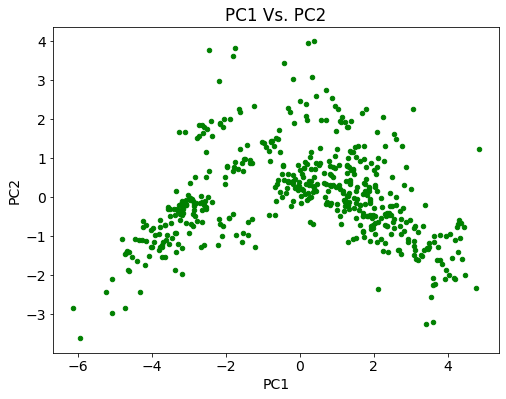

In [14]:
plt.rcParams['figure.figsize']=8,6
plt.rcParams['font.size']=14
ax1=df_pca.plot.scatter(title='PC1 Vs. PC2',x='PC1',y='PC2',c='green')
     

In [15]:
output=assembler.transform(df2)
f_data=output.select('features','medv')
f_data.show(5)

+--------------------+----+
|            features|medv|
+--------------------+----+
|[0.00632,18.0,2.3...|24.0|
|[0.02731,0.0,7.07...|21.6|
|[0.02729,0.0,7.07...|34.7|
|[0.03237,0.0,2.18...|33.4|
|[0.06905,0.0,2.18...|36.2|
+--------------------+----+
only showing top 5 rows



In [16]:
train_data,test_data= f_data.randomSplit([0.90,0.1])


In [17]:
regressor=LinearRegression(featuresCol='features',labelCol='medv')
regressor=regressor.fit(train_data)

In [18]:
coeff=regressor.coefficients
intr=regressor.intercept
print("The coefficient of the model is found to be:", coeff)
print("The intercept of the model is found to be:", intr)

print("The coefficient of the model is found to be: %a" %coeff)
print("The intercept of the model is found to be: %f" %intr)

The coefficient of the model is found to be: [-0.10399900142427762,0.038287576538492664,0.058278189657902525,1.7726044111416446,-17.457055911351624,4.333053074231104,0.0064680365158864585,-1.2913178590096832,0.2776657459585829,-0.01267914915647189,-0.9711004046638075,0.009313466496959926,-0.5120021759930266]
The intercept of the model is found to be: 32.07904353085563
The coefficient of the model is found to be: DenseVector([-0.104, 0.0383, 0.0583, 1.7726, -17.4571, 4.3331, 0.0065, -1.2913, 0.2777, -0.0127, -0.9711, 0.0093, -0.512])
The intercept of the model is found to be: 32.079044


In [19]:
pred= regressor.evaluate(test_data)
pred.predictions.show(5)

+--------------------+----+------------------+
|            features|medv|        prediction|
+--------------------+----+------------------+
|[0.01501,90.0,1.2...|50.0| 43.88395130922832|
|[0.01538,90.0,3.7...|44.0| 37.50628076315262|
|[0.03502,80.0,4.9...|28.5| 32.90497521758448|
|[0.03551,25.0,4.8...|22.9|24.819031969118686|
|[0.0456,0.0,13.89...|23.3|25.615542296035848|
+--------------------+----+------------------+
only showing top 5 rows



In [20]:
from pyspark.ml.evaluation import RegressionEvaluator
eval=RegressionEvaluator(labelCol='medv',predictionCol='prediction',metricName='rmse')

rmse=eval.evaluate(pred.predictions)
print("RMSE : %.3f" %rmse)

mse=eval.evaluate(pred.predictions,{eval.metricName:"mse"})
print("MSE : %.3f" %mse)

mae=eval.evaluate(pred.predictions,{eval.metricName:"mae"})
print("MAE : %.3f" % mae)

r2=eval.evaluate(pred.predictions,{eval.metricName:"r2"})
print("r2 : %.3f" %r2)

RMSE : 5.502
MSE : 30.270
MAE : 3.470
r2 : 0.556
